## Multivariate Linear Regression

Building on our univariate linear regression model, we will take a look at the multivariate case. Our sample dataset contains housing prices for Portland, Oregon. Features consist of size (square footage) and # of bedrooms.

In [1]:
import numpy as np
from numpy.linalg import pinv
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def scale_features(X, means=None, stds=None):
    """Scale initial X matrix columns as (x - mean)/std."""
    if means is None and stds is None:
        means = X.mean(axis=0)
        stds = X.std(axis=0)
    X = (X - means) / stds
    return X, means, stds

In [3]:
def cost(X, y, theta):
    """Calculate value of cost function for given theta."""
    m = X.shape[0]
    h = X.dot(theta)
    sum_squared_loss = (h - y).T.dot(h - y)
    error = sum_squared_loss / (2 * m)
    return round(error, 3)

In [4]:
def gradient_descent(X, y, theta, alpha, iterations, min_improvement=0.00001):
    """Run given # of iterations of gradient descent, starting with theta as
    a zero vector, to find optimal values of theta to minimize cost."""
    m = X.shape[0]
    cost_vals = []
    for i in range(iterations):
#         if (i > 0) & (i % 100 == 0):
#             if cost_vals[-2] - cost_vals[-1] < min_improvement:
#                 print('Converged after {} iterations.'.format(i))
#                 break
        cost_vals.append(cost(X, y, theta))
        h = X.dot(theta)                  # mx1
        loss = h - y                      # mx1
        gradient = X.T.dot(loss)          # nx1
        theta = theta - (alpha/m) * gradient
    return theta, cost_vals

In [5]:
def scale_predict(X, theta, means, stds):
    """Pass in X as a numpy array and scale using the parameters calculated 
    on the initial dataset. Returns the predicted values using the weights 
    optimized through gradient descent.
    """
    X = scale_features(X, means, stds)[0]
    X = np.column_stack((np.ones(X.shape[0]), X))
    return X.dot(theta)

In [6]:
def predict(X, theta):
    """Pass in X as numpy array with scaled features and bias column.
    Return predicted y values."""
    return X.dot(theta)

In [7]:
def normal_equation(X, y):
    """Calculate weights using normal equation."""
    t1 = np.linalg.pinv(np.dot(X.T, X))
    t2 = np.dot(X.T, y)
    return np.dot(t1, t2)

## Load Dataset

In [8]:
data_multi = np.loadtxt(r'data/ex1data2.txt', delimiter=',')
m = data_multi.shape[0]
n = data_multi[:,:-1].shape[1]

# x1 = square footage, x2 = # of bedrooms
# y = sale price
X = data_multi[:,:-1]
y = data_multi[:,-1]

print('m, n: ({},{})'.format(m, n))
print('\nX dimensions:', X.shape)
print('\ny dimensions:', y.shape)

m, n: (47,2)

X dimensions: (47, 2)

y dimensions: (47,)


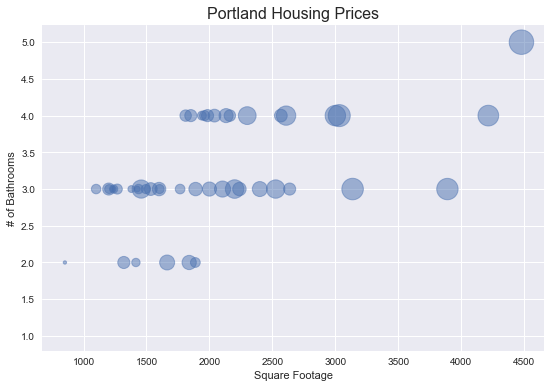

In [9]:
bubble_sizes = 600 * (y - y.min() + 1) / (y.max() - y.min())

fig, ax = plt.subplots(figsize=(9,6))
ax.scatter(X[:,0], X[:,1], s=bubble_sizes, alpha=0.5, linewidths=1)
plt.title('Portland Housing Prices', fontsize=16)
plt.xlabel('Square Footage')
plt.ylabel('# of Bathrooms')
plt.show()

## Feature Scaling

In [10]:
# Normalize features and add bias column.
X_scaled, col_means, col_stds = scale_features(X)
X_scaled = np.column_stack((np.ones(m), X_scaled))

print('Feature means:', col_means)
print('\nFeature standard deviations:', col_stds)

Feature means: [2000.68085106    3.17021277]

Feature standard deviations: [7.86202619e+02 7.52842809e-01]


## Gradient Descent

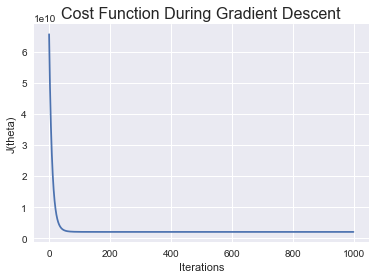

Weights: [340412.65957447 109447.796457    -6578.35484152]
Cost: 2043280050.603


In [11]:
theta_multi = np.zeros(n+1)
alpha = 0.05
iterations = 1000
theta_m_vals, costs = gradient_descent(X_scaled, y, theta_multi, alpha, 
                                       iterations)
plt.plot(costs)
plt.title('Cost Function During Gradient Descent', fontsize=16)
plt.xlabel('Iterations')
plt.ylabel('J(theta)')
plt.show()

print('Weights:', theta_m_vals)
print('Cost:', costs[-1])

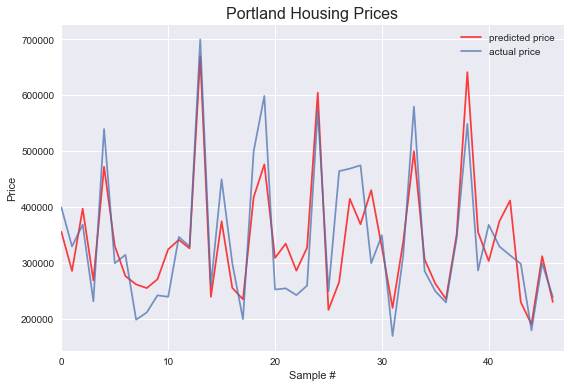

In [12]:
price_preds = predict(X_scaled, theta_m_vals)

fig, ax = plt.subplots(figsize=(9,6))
ax.plot(range(y.shape[0]), price_preds, alpha=0.75, color='red', 
        label='predicted price')
ax.plot(range(y.shape[0]), y, alpha=0.75, label='actual price')
plt.title('Portland Housing Prices', fontsize=16)
plt.xlabel('Sample #')
plt.ylabel('Price')
plt.xlim(0,47)
plt.legend(loc='upper right')
plt.show()

In [31]:
sample_house = np.array([[1650, 3]])
sample_pred = scale_predict(sample_house, theta_m_vals, col_means, col_stds)

print('Sample prediction: 1650 sq ft, 3 bedrooms:\n${}'\
      .format(np.squeeze(np.round(sample_pred, 2))))

Sample prediction: 1650 sq ft, 3 bedrooms:
$293081.46


## Normal Equation

For comparison, use the normal equation to find theta values.

In [14]:
norm_eq_theta = normal_equation(X_scaled, y)
norm_prediction = scale_predict(np.array([[1650, 3]]), norm_eq_theta,
                                col_means, col_stds)

print('Theta values from normal equation:\n{}'.format(norm_eq_theta))
print('\nSample prediction: 1650 sq feet, 3 bedrooms')
print(np.squeeze(norm_prediction))

Theta values from normal equation:
[340412.65957447 109447.79646964  -6578.35485416]

Sample prediction: 1650 sq feet, 3 bedrooms
293081.4643348962


# scikit-learn Implementation

For comparison, let's train a roughly equivalent model using scikit-learn.

In [48]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

# Load data and split into X and y dataframes.
df = pd.read_csv(r'data/ex1data2.txt', names=['square_ft','bedrooms','price'])

X = df.iloc[:,:-1]
y = df.iloc[:,-1]
print('X\n\n' + str(X.head()))
print('\ny\n\n' + str(y.head()))

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

X

   square_ft  bedrooms
0       2104         3
1       1600         3
2       2400         3
3       1416         2
4       3000         4

y

0    399900
1    329900
2    369000
3    232000
4    539900
Name: price, dtype: int64


In [49]:
# IN PROGRESS - BUILDING PIPELINE TO STREAMLINE FIT/PREDICT PROCESS
pipe = Pipeline([('sc', StandardScaler()), ('lr', LinearRegression())])
pipe.fit(X_train, y_train)
mses = cross_val_score(pipe, X_train, y_train, cv=3, 
                       scoring='neg_mean_squared_error')
j = -np.mean(mses)
weights_skl = np.array([pipe.named_steps['lr'].intercept_, 
                        *pipe.named_steps['lr'].coef_])

print('Mean squared error: ' + str(j))
print('Weights: ' + str(weights_skl))

Mean squared error: 7921094368.961619
Weights: [342531.31428571 100618.32452246  -1663.68009502]


In [59]:
np.column_stack((X_test, test_preds))

array([[1.32000000e+03, 2.00000000e+00, 2.49933696e+05],
       [1.89000000e+03, 3.00000000e+00, 3.24294028e+05],
       [1.66400000e+03, 2.00000000e+00, 2.96252686e+05],
       [1.98500000e+03, 4.00000000e+00, 3.34696453e+05],
       [1.96200000e+03, 4.00000000e+00, 3.31599544e+05],
       [4.47800000e+03, 5.00000000e+00, 6.67985323e+05],
       [2.40000000e+03, 3.00000000e+00, 3.92964623e+05],
       [1.60400000e+03, 3.00000000e+00, 2.85784636e+05],
       [1.20000000e+03, 3.00000000e+00, 2.31386753e+05],
       [2.30000000e+03, 4.00000000e+00, 3.77110644e+05],
       [8.52000000e+02, 2.00000000e+00, 1.86918327e+05],
       [1.38000000e+03, 3.00000000e+00, 2.55623433e+05]])

In [61]:
test_preds = pipe.predict(X_test)
test_mse = mean_squared_error(y_test, test_preds)
test_df = pd.DataFrame(data=np.column_stack((X_test, y_test, test_preds)),
          columns=['square_ft', 'bedrooms', 'actual_price', 'predictions'])
#test_df['actual'] = y_test.reset_index(drop=True)

print('Test set - mean squared error: ' + str(test_mse) + '\n')
print(test_df)
print(test_preds)

Test set - mean squared error: 2446209538.5694747

    square_ft  bedrooms  actual_price    predictions
0      1320.0       2.0      299900.0  249933.696372
1      1890.0       3.0      329999.0  324294.028296
2      1664.0       2.0      368500.0  296252.686021
3      1985.0       4.0      299900.0  334696.453000
4      1962.0       4.0      259900.0  331599.543808
5      4478.0       5.0      699900.0  667985.322994
6      2400.0       3.0      369000.0  392964.623416
7      1604.0       3.0      242900.0  285784.635738
8      1200.0       3.0      299000.0  231386.752545
9      2300.0       4.0      449900.0  377110.644103
10      852.0       2.0      179900.0  186918.326732
11     1380.0       3.0      212000.0  255623.433175
[249933.69637165 324294.02829559 296252.68602132 334696.45299977
 331599.54380808 667985.32299445 392964.62341575 285784.63573801
 231386.75254478 377110.6441034  186918.32673197 255623.43317543]


In [43]:
cross_val_predict(pipe, X_test, cv=3)

TypeError: Singleton array array(None, dtype=object) cannot be considered a valid collection.

In [21]:
sample_pred_skl = pipe.predict([[1650, 3]])
print('Sample prediction (1650 sq ft, 3 bathrooms): $' + 
      str(np.squeeze(sample_pred_skl)))

Sample prediction (1650 sq ft, 3 bathrooms): $295507.5151440422


# old method - no pipeline

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

# Perform feature scaling.
sc = StandardScaler()
X_train = sc.fit_transform(X_train)

# Fit linear regression model to data and predict price for sample house.
lr = LinearRegression(normalize=True)
lr.fit(X_train, y_train)
theta0 = lr.intercept_
theta1, theta2 = lr.coef_
print('Theta values:', theta0, theta1, theta2)

sample_pred_old = sc.transform(np.array([1650, 3]).reshape(1, -1))
prediction = lr.predict(sample_pred_old)
print('Sample prediction: 1650 square feet, 3 bedrooms\n{}'.format(prediction[0]))

Theta values: 345571.4 101427.65746476926 -18956.098274342443
Sample prediction: 1650 square feet, 3 bedrooms
293253.2831374962


C:\Users\Harrison Mamin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
